In [ ]:
  # sets *your* project id
PROJECT_ID = "PROJECT_ID" #@param {type:"string"}

In [ ]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_0_2' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

# **Obtain Authorization to access the database**



In [ ]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


# **Loading data using DataTable**


In [ ]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000

# **Creating a configuration query using "bigquery"**

In [ ]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config

## **Reading in admissions data**

In [ ]:
%%bigquery admissions
SELECT * FROM admissions

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
admissions.head(1000)

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,destination,gender,agegroup,dateofdeath,weightgroup,weightsource,heightgroup,heightsource,specialty
0,117,130,1,MC,0,None,0,2003-2009,91560000,26,None,Man,70-79,<NA>,70-79,None,180-189,None,None
1,570,656,1,MC,0,None,0,2003-2009,90780000,25,None,Man,70-79,229442400000,60-69,None,160-169,None,None
2,700,799,1,MC,0,None,0,2003-2009,104460000,29,None,Man,60-69,<NA>,70-79,None,170-179,None,None
3,817,941,1,MC,0,None,0,2003-2009,86580000,24,None,Man,70-79,162649800000,60-69,None,160-169,None,None
4,951,1098,1,MC,0,None,0,2003-2009,75000000,20,None,,70-79,<NA>,60-69,None,170-179,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1923,2211,1,IC,0,None,0,2010-2016,83940000,23,15,Vrouw,70-79,34519620000,70-79,None,170-179,None,Cardiochirurgie
996,1927,2215,1,IC,0,None,0,2003-2009,281400000,78,15,Vrouw,60-69,<NA>,90-99,None,160-169,None,Cardiochirurgie
997,1930,2218,1,IC,0,CCU/IC zelfde ziekenhuis,0,2010-2016,88500000,24,15,Man,60-69,<NA>,90-99,None,160-169,None,Cardiochirurgie
998,1934,2223,1,IC,0,None,0,2003-2009,70200000,19,15,Man,60-69,<NA>,70-79,None,170-179,None,Cardiochirurgie


**Using Python pandas to manipulate the tables**

In [ ]:
import pandas as pd

config_gbq = {'query':
          {'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

In [ ]:
admissions['urgency'].value_counts()

0    16860
1     6246
Name: urgency, dtype: Int64

# **Overview of database**



*   ## This database contains data for the period 01/01/2003 - 31/12/2016.
*   ## Number of total admissions:23016
        Number of Planned admissions:16860
        Number of Emergency admissions:6246  
*   ## In this period, there are 5114 days; 3556 days are weekdays and 1461 days are weekends. There are 142 holidays, 45 days of them are the weekends. Therefore, we have 3556 working days and 1558 non-working days.

*  ## This period contains 730 weeks and 4 days.








In [ ]:
# Calculate the admission rates
avg_emergency_admission = round(6246/5114,2)
avg_planned_admission = round(16860/3556,2)

### **Creating a smaller table which includes data for "length of stays" and "urgency level" of each admission**

In [ ]:
df_admission = admissions[['patientid','admissionid','lengthofstay','urgency']].copy()

In [ ]:
df_admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23106 entries, 0 to 23105
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   patientid     23106 non-null  Int64
 1   admissionid   23106 non-null  Int64
 2   lengthofstay  23106 non-null  Int64
 3   urgency       23106 non-null  Int64
dtypes: Int64(4)
memory usage: 812.4 KB


### **Calculating "Number of Admissions" for each "Length of stays" for all admissions.**

In [ ]:
for value in df_admission['lengthofstay'].values:
  df_admission.loc[df_admission['lengthofstay'] == value, 'number_of_admissions']= df_admission['lengthofstay'].value_counts().at[value]
  df_admission.loc[df_admission['lengthofstay'] == value, 'probability']= df_admission['lengthofstay'].value_counts(normalize = True).at[value]

df_admission


### **Calculating "Number of Emergency Admissions" for each "Length of stays" for all admissions.**

In [ ]:
df_admission_emergency = df_admission.drop(columns=['probability'])

df_admission_emergency = df_admission_emergency.loc[df_admission['urgency']==1]
df_admission_emergency

### **Recalculating the probability of occurrence of a "Length of Stay" for emergency admissions**

In [ ]:
for value in df_admission_emergency['lengthofstay'].values:
  df_admission_emergency.loc[df_admission_emergency['lengthofstay'] == value, 'number_of_admissions']= df_admission_emergency['lengthofstay'].value_counts().at[value]
  df_admission_emergency.loc[df_admission_emergency['lengthofstay'] == value, 'probability']= df_admission_emergency['lengthofstay'].value_counts(normalize = True).at[value]

df_admission_emergency.sort_values('lengthofstay')

### **A plot showing the distribution of emergency admissions based on their length of stays.**




<BarContainer object of 6051 artists>

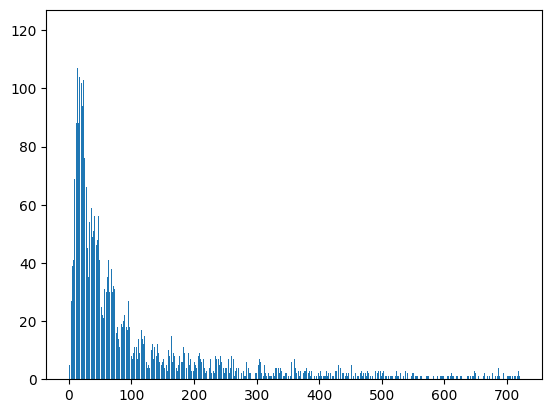

In [ ]:
from matplotlib import pyplot as plt
df_admission_emergency_short = df_admission_emergency[df_admission_emergency['lengthofstay']<=720]
plt.bar(df_admission_emergency_short['lengthofstay'],df_admission_emergency_short['number_of_admissions'])

<BarContainer object of 5586 artists>

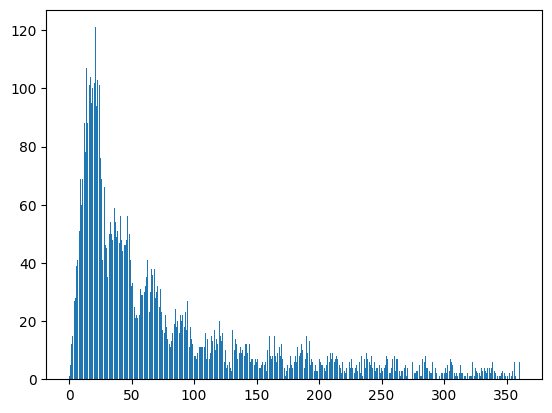

In [ ]:
from matplotlib import pyplot as plt
df_admission_emergency_veryshort = df_admission_emergency[df_admission_emergency['lengthofstay']<=360]
plt.bar(df_admission_emergency_veryshort['lengthofstay'],df_admission_emergency_veryshort['number_of_admissions'])

### **Calculating "Number of Planned Admissions" and their probability of occurrence for each "Length of Stays" for all admissions.**

In [ ]:
df_admission_planned = df_admission.drop(columns=['probability'])
df_admission_planned = df_admission_planned.loc[df_admission['urgency']==0]
for value in df_admission_planned['lengthofstay'].values:
  df_admission_planned.loc[df_admission_planned['lengthofstay'] == value, 'number_of_admissions']= df_admission_planned['lengthofstay'].value_counts().at[value]
  df_admission_planned.loc[df_admission_planned['lengthofstay'] == value, 'probability']= df_admission_planned['lengthofstay'].value_counts(normalize = True).at[value]

df_admission_planned.sort_values('lengthofstay')

### **A plot showing the distribution of planned admissions based on their length of stays.**

<BarContainer object of 15718 artists>

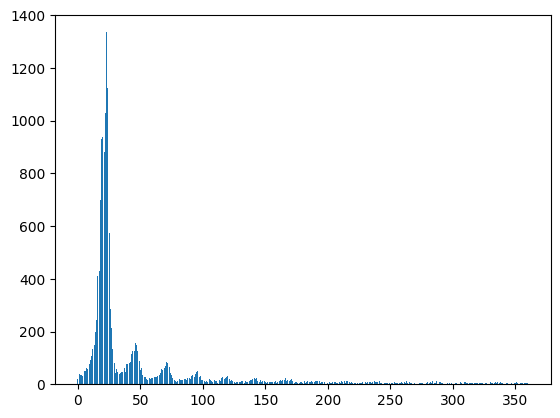

In [ ]:
from matplotlib import pyplot as plt
df_admission_planned_veryshort = df_admission_planned[df_admission_planned['lengthofstay']<=360]
plt.bar(df_admission_planned_veryshort['lengthofstay'],df_admission_planned_veryshort['number_of_admissions'])

# **To run the simulation for one time and to see the relevant data and plots, run the following blocks. If you want to run the simulation more than once go to the next block.**


## **Description of Simulation**
I have written the simulation code using SimPy simulation framework of Python. It runs for 365 days. The ICU bed occupancy gets updated at the end of each days. This simulation has a two-fold application. It can predict the bed occupancy in a normal condition based on data provided by Amsterdam UMC database . Moreover, based on the extracted data from the database for all patients with ARDS a pandemic-like simulation is also executed. Both situations are within the same code; to achieve either a normal or a pandemic-like situation, one can change the values of the relevant variables in  the code.

In [ ]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# In order to run the simulation for one time and to see the relevant data and plots, run the following blocks. If you want to run the simulation for many times go to the next block.

In [ ]:
from pickle import FALSE
import random
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


## **Simulating ICU admissions at a given day**


---



### **Calculating ICU admisssion rate for the simulation**


We use three different approaches to do so:

1.   Using a Log-Normal Distribution with the mean ($\mu$ parameter) of logarithm of distribution obtained from the real data, $\mu = \log{(\textrm{average admissions})}$
2.   Using a Poisson Distribution with the mean of length of stay obtained from the real data, based on Amesterdam UCM database $\textrm{mean} = 22$ (see above plots).
3.   Random choice of lengths of stays wighted using the probability of Planned, Emergency or Pandemic ARDS distribution calculated above.


**Note 1: In this simulation, we have considered that Planned admissions only occur on weekdays while Emergency admissions happen every day.**

**Note 2: We have assumed a $\mu$ parameter for the pandemic simulation as $ \mu_{\textrm{Pandemic}} = 2(\mu_{\textrm{Planned}} + \mu_{\textrm{Emergency}})$.**



In [ ]:
# Calculate the admission rates

avg_emergency_admission = 6246/5114
avg_planned_admission = 16860/3556
emergency_mu_parameter = np.log(avg_emergency_admission)
planned_mu_parameter = np.log(avg_planned_admission)


# Define the number of ICU beds
icu_beds = 20

# Initialize the extra_beds_needed variable
extra_beds_needed = 1


In [ ]:
# Function to simulate ICU admissions for a given day
def simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay):
    # Get the current date and check if it's a weekday or weekend
    current_day = env.now  # Increment by 1 since simulation starts from day 0
    is_weekday = current_day % 7 < 5  # Monday = 0, ..., Friday = 4


    print(f'today value is{current_day}')

    # Define the planned admission rate (number of planned admissions per weekday)
    planned_admission_rate = round(np.random.lognormal(planned_mu_parameter,sigma=0.5))

    # Define the number of emergency admissions per day (can vary)
    emergency_admission_rate = round(np.random.lognormal(emergency_mu_parameter,sigma=0.5))

    # Simulate ICU admissions for the day
    if use_poisson_distribution:
        admissions_emergency = np.random.poisson(mean_length_of_stay, emergency_admission_rate)
        admissions_planned = np.random.poisson(mean_length_of_stay, planned_admission_rate)
        # Calculate the total admission rate based on the type of admission
        if is_weekday:
          admissions = np.append(admissions_emergency, admissions_planned)
        else:
          admissions = admissions_emergency

        print(f"admission was selected from a random Poisson distribution with mean ={mean_length_of_stay}")
    else:
        admissions_emergency = np.random.choice(emergency_length_of_stay_distribution, size = emergency_admission_rate, p=emergency_probability_length_of_stay_data_array)
        admissions_planned = np.random.choice(planned_length_of_stay_distribution, size = planned_admission_rate, p=planned_probability_length_of_stay_data_array)
        # Calculate the total admission rate based on the type of admission
        if is_weekday:
          admissions = np.append(admissions_emergency, admissions_planned)
          print(f'admission on weekday')
          print(f'number of admissions:{len(admissions)}')
        else:
          admissions = admissions_emergency
          print(f'admission on not_a_weekday')
          print(f'number of admissions:{len(admissions)}')

        #admissions = np.random.choice(length_of_stay_distribution, size = total_admission_rate, p=probability_length_of_stay_data_array)
        print(f'admission:{admissions}')
    admission_priority = [0] * planned_admission_rate + [1] * emergency_admission_rate

    return admissions, admission_priority

### **This Function updates the ICU bed occupancy at the end of each day of simulation by taking into account the discharged patients on each day of simulation**

In [ ]:
# Function to update occupancy and occupied beds
def update_occupancy(admissions, icu_beds_capacity, occupied_beds):
    # Extend occupied_beds by admissions
    occupied_beds.extend(admissions)
    beginning_of_day_occupancy = len(occupied_beds)

    # Check if the size of ocupied_beds is smaller than the number of icu_beds
 #   if len(occupied_beds) < icu_beds_capacity.capacity:
        # Change occupied_beds to a list only containing values bigger than 24
        # and subtract 24 from the remaining values
    occupied_beds = [(val - 24) for val in occupied_beds if val > 24]

    end_of_day_occupancy = len(occupied_beds)
    discharged = beginning_of_day_occupancy - end_of_day_occupancy
    occupancy = beginning_of_day_occupancy - discharged



    return beginning_of_day_occupancy, occupancy, occupied_beds



## **Function to define the Simulation Process**

In [ ]:
# Simulation process
def simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed, mean_length_of_stay):
    occupancy = 0
    occupied_beds = []
    bed_capacity_reached = False

    half_time = 365 / 2

    current_day = 0  # Initialize current_day to 0, SIMULATION STARTS ON MONDAY

    while True:
        admissions, admission_priority = simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay)

        with icu_beds_capacity.request(priority=max(admission_priority)) as request:
            yield request

            beginning_of_day_occupancy, occupancy, occupied_beds = update_occupancy(admissions, icu_beds_capacity, occupied_beds)

            # Append data to occupancy and bed capacity lists
            occupancy_BOD_data.append(beginning_of_day_occupancy)
            occupancy_EOD_data.append(occupancy)
            bed_capacity_data.append(icu_beds_capacity.capacity)
            #admission_rate_data.append(total_admission_rate)
            emergency_admission_rate_data.append(admission_priority.count(1))
            planned_admission_rate_data.append(admission_priority.count(0))







        yield env.timeout(1)
        current_day += 1  # Increment current_day by 1 after each simulation loop

## **Deciding that which of the calculations for admission rate we use and calculate the relevant data to compute the corresponding distributions**

In [ ]:
# Define the length of stay distribution

use_poisson_distribution = False
real_data = True
mean_length_of_stay = 22

if use_poisson_distribution:
    mean_length_of_stay = 22  # Mean length of stay for Poisson distribution

elif real_data :     # Set to True if using real data

    emergency_length_of_stay_data = df_admission_emergency['lengthofstay']  # Assuming 'lengthofstay' is the column name in the DataFrame
    emergency_probability_length_of_stay_data = df_admission_emergency['probability']

    emergency_length_of_stay_data_array = emergency_length_of_stay_data.values
    emergency_probability_length_of_stay_data_array = emergency_probability_length_of_stay_data.values

    planned_length_of_stay_data = df_admission_planned['lengthofstay']  # Assuming 'lengthofstay' is the column name in the DataFrame
    planned_probability_length_of_stay_data = df_admission_planned['probability']

    planned_length_of_stay_data_array = planned_length_of_stay_data.values
    planned_probability_length_of_stay_data_array = planned_probability_length_of_stay_data.values

    # Normalize the probabilities
    emergency_probability_length_of_stay_data_array /= np.sum(emergency_probability_length_of_stay_data_array)
    planned_probability_length_of_stay_data_array /= np.sum(planned_probability_length_of_stay_data_array)


    emergency_length_of_stay_distribution = emergency_length_of_stay_data_array

    planned_length_of_stay_distribution = planned_length_of_stay_data_array
    print(f"Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = ({planned_mu_parameter},{emergency_mu_parameter}) for planned and emergency admissions respectively.")
else:
    emergency_length_of_stay_distribution = np.random.randint(0, 50, size=(1, 10))
    planned_length_of_stay_distribution = np.random.randint(0, 50, size=(1, 10))
    print(f"Admissions was selected from a random selection of random integer numbers")



Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = (1.5563076349220513,0.19995938199189203) for planned and emergency admissions respectively.


## **Initializing empty lists to store data for bed occupancy and admission rates on each day of simulation**

In [ ]:
# Create lists to store occupancy and bed capacity data
occupancy_BOD_data = []
occupancy_EOD_data = []
bed_capacity_data = []
#admission_rate_data = []
emergency_admission_rate_data = []
planned_admission_rate_data = []


## **Setting the Simulation environment and ruuning it for 365 days of simulation**

In [ ]:
# Run the simulation
env = simpy.Environment()
icu_beds_capacity = simpy.PriorityResource(env, capacity=icu_beds)
extra_beds_needed = simpy.Resource(env, capacity=extra_beds_needed)
simulation = env.process(simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed,  mean_length_of_stay))
env.run(until=365)


today value is0
admission on weekday
number of admissions:7
admission:[21 8 18 22 18 18 20]
today value is1
admission on weekday
number of admissions:6
admission:[21 69 19 16 19 19]
today value is2
admission on weekday
number of admissions:8
admission:[23 200 23 23 23 14 23 18]
today value is3
admission on weekday
number of admissions:7
admission:[11 252 22 20 19 19 16]
today value is4
admission on weekday
number of admissions:8
admission:[9 25 16 22 22 24 18 22]
today value is5
admission on not_a_weekday
number of admissions:2
admission:[23 23]
today value is6
admission on not_a_weekday
number of admissions:3
admission:[17 26 21]
today value is7
admission on weekday
number of admissions:11
admission:[21 24 18 23 24 23 24 23 21 23 23]
today value is8
admission on weekday
number of admissions:5
admission:[15 16 22 22 16]
today value is9
admission on weekday
number of admissions:8
admission:[46 16 24 19 20 16 21 20]
today value is10
admission on weekday
number of admissions:6
admission:[

## **Making a table of collected data from simulation and Plotting them**

In [ ]:
# Print the simulation results

# Create a pandas DataFrame
data = {'Planned admissions': planned_admission_rate_data, 'Emergency admissions': emergency_admission_rate_data, 'Beds occupied during the day': occupancy_BOD_data, 'Occupancy at the end of day': occupancy_EOD_data, 'Bed Capacity': bed_capacity_data}
df_data = pd.DataFrame(data)

# Print the DataFrame
df_data


,Planned admissions,Emergency admissions,Beds occupied during the day,Occupancy at the end of day,Bed Capacity
0,5,2,7,0,20
1,4,2,6,1,20
2,6,2,9,2,20
3,5,2,9,2,20
4,5,3,10,3,20
...,...,...,...,...,...
360,3,1,5,0,20
361,3,2,5,2,20
362,2,1,3,1,20
363,6,3,4,1,20


In [ ]:
df_data['Planned admissions'].mean()

5.627397260273972

In [ ]:
df_data['Emergency admissions'].mean()

1.4657534246575343

**Description of Plot:**

* Blue plot is depicting the number of occupied beds at the end of each day of simulation

* Orange plot is depicting the maximum number of occupied beds at each day of simulation

**Note: At the beginning of each day of simulation all admitted patients are counted. Due to the removal of time stamp from data for anonymization purposes, we could not input admission data in an hourly base.**

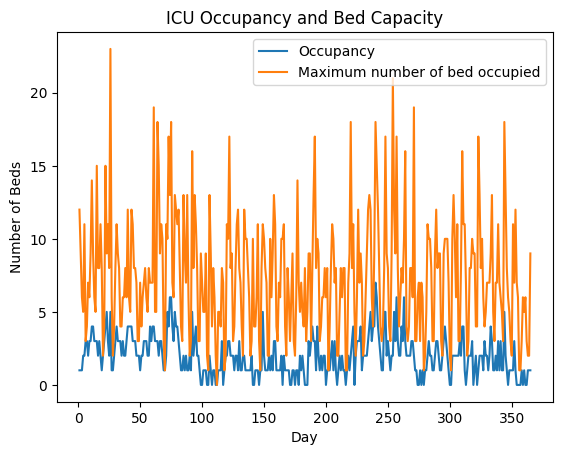

In [ ]:
# Plot the occupancy and bed capacity data
days = np.arange(1, len(occupancy_EOD_data) + 1)

plt.plot(days, occupancy_EOD_data, label='Occupancy')
plt.plot(days, occupancy_BOD_data, label='Maximum number of bed occupied')
plt.xlabel('Day')
plt.ylabel('Number of Beds')
plt.title('ICU Occupancy and Bed Capacity')
plt.legend()
plt.show()

In [ ]:
df_data['Beds occupied during the day'].nlargest(10)

25     23
253    21
60     19
270    19
63     18
74     18
219    18
239    18
343    18
72     17
Name: Beds occupied during the day, dtype: int64

In [ ]:
df_data['Beds occupied during the day'].max()

23

# **To have a better grasp at the statiscs behind the simulation, we create an ensemble of simulations.**

## **To run the simulation for 1000 times and compre the maximum number of occupancy run the following block.**

In [ ]:
from pickle import FALSE
import random
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta






# Calculate the admission rates
#avg_emergency_admission = round(6246/5114,2)
#avg_planned_admission = round(16860/3556,2)
avg_emergency_admission = 6246/5114
avg_planned_admission = 16860/3556
emergency_mu_parameter = np.log(avg_emergency_admission)
planned_mu_parameter = np.log(avg_planned_admission)



# Define the number of ICU beds
icu_beds = 20

# Initialize the extra_beds_needed variable
extra_beds_capacity = 1

# Create lists to store occupancy and bed capacity data for each run
all_occupancy_BOD_data = []
all_occupancy_EOD_data = []
all_bed_capacity_data = []
all_admission_rate_data = []
all_emergency_admissions_rate_data = []
all_planned_admissions_rate_data = []


# Function to simulate ICU admissions for a given day
def simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay):
    # Get the current date and check if it's a weekday or weekend
    current_day = env.now  # Increment by 1 since simulation starts from day 0
    is_weekday = current_day % 7 < 5  # Monday = 0, ..., Friday = 4

    #print(f'today value is{current_day}')

    # Define the planned admission rate (number of planned admissions per weekday)
    planned_admission_rate = round(np.random.lognormal(planned_mu_parameter,sigma=0.5))

    # Define the number of emergency admissions per day (can vary)
    emergency_admission_rate = round(np.random.lognormal(emergency_mu_parameter,sigma=0.5))


    # Simulate ICU admissions for the day
    if use_poisson_distribution:
        admissions_emergency = np.random.poisson(mean_length_of_stay, emergency_admission_rate)
        admissions_planned = np.random.poisson(mean_length_of_stay, planned_admission_rate)
        # Calculate the total admission rate based on the type of admission
        if is_weekday:
          admissions = np.append(admissions_emergency, admissions_planned)
        else:
          admissions = admissions_emergency

        print(f"admission was selected from a random Poisson distribution with mean ={mean_length_of_stay}")
    else:
        admissions_emergency = np.random.choice(emergency_length_of_stay_distribution, size = emergency_admission_rate, p=emergency_probability_length_of_stay_data_array)
        admissions_planned = np.random.choice(planned_length_of_stay_distribution, size = planned_admission_rate, p=planned_probability_length_of_stay_data_array)
        # Calculate the total admission rate based on the type of admission
        if is_weekday:
          admissions = np.append(admissions_emergency, admissions_planned)
          #print(f'admission on weekday')
          #print(f'number of admissions:{len(admissions)}')
        else:
          admissions = admissions_emergency
          #print(f'admission on not_a_weekday')
          #print(f'number of admissions:{len(admissions)}')

        #admissions = np.random.choice(length_of_stay_distribution, size = total_admission_rate, p=probability_length_of_stay_data_array)
        #print(f'admission:{admissions}')
    admission_priority = [0] * planned_admission_rate + [1] * emergency_admission_rate

    return admissions, admission_priority


# Function to update occupancy and occupied beds
def update_occupancy(admissions, icu_beds_capacity, occupied_beds):
    # Extend occupied_beds by admissions
    occupied_beds.extend(admissions)
    beginning_of_day_occupancy = len(occupied_beds)

    # Check if the size of ocupied_beds is smaller than the number of icu_beds
 #   if len(occupied_beds) < icu_beds_capacity.capacity:
        # Change occupied_beds to a list only containing values bigger than 24
        # and subtract 24 from the remaining values
    occupied_beds = [(val - 24) for val in occupied_beds if val > 24]

    end_of_day_occupancy = len(occupied_beds)
    discharged = beginning_of_day_occupancy - end_of_day_occupancy
    occupancy = beginning_of_day_occupancy - discharged



    return beginning_of_day_occupancy, occupancy, occupied_beds



# Simulation process
def simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed, mean_length_of_stay):
    occupancy = 0
    occupied_beds = []
    bed_capacity_reached = False

    half_time = 365 / 2

    current_day = 0  # Initialize current_day to 0, SIMULATION STARTS ON MONDAY

    while True:
        admissions, admission_priority = simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay)

        with icu_beds_capacity.request(priority=max(admission_priority)) as request:
            yield request

            beginning_of_day_occupancy, occupancy, occupied_beds = update_occupancy(admissions, icu_beds_capacity, occupied_beds)

            # Append data to occupancy and bed capacity lists
            occupancy_BOD_data.append(beginning_of_day_occupancy)
            occupancy_EOD_data.append(occupancy)
            bed_capacity_data.append(icu_beds_capacity.capacity)
            emergency_admissions_rate_data.append(admission_priority.count(1))
            planned_admissions_rate_data.append(admission_priority.count(0))



        yield env.timeout(1)
        current_day += 1  # Increment current_day by 1 after each simulation loop

# Define the length of stay distribution

use_poisson_distribution = False
real_data = True
mean_length_of_stay = 22

if use_poisson_distribution:
    mean_length_of_stay = 22  # Mean length of stay for Poisson distribution

elif real_data :     # Set to True if using real data

    emergency_length_of_stay_data = df_admission_emergency['lengthofstay']  # Assuming 'lengthofstay' is the column name in the DataFrame
    emergency_probability_length_of_stay_data = df_admission_emergency['probability']

    emergency_length_of_stay_data_array = emergency_length_of_stay_data.values
    emergency_probability_length_of_stay_data_array = emergency_probability_length_of_stay_data.values

    planned_length_of_stay_data = df_admission_planned['lengthofstay']  # Assuming 'lengthofstay' is the column name in the DataFrame
    planned_probability_length_of_stay_data = df_admission_planned['probability']

    planned_length_of_stay_data_array = planned_length_of_stay_data.values
    planned_probability_length_of_stay_data_array = planned_probability_length_of_stay_data.values

    # Normalize the probabilities
    emergency_probability_length_of_stay_data_array /= np.sum(emergency_probability_length_of_stay_data_array)
    planned_probability_length_of_stay_data_array /= np.sum(planned_probability_length_of_stay_data_array)


    emergency_length_of_stay_distribution = emergency_length_of_stay_data_array

    planned_length_of_stay_distribution = planned_length_of_stay_data_array
    print(f"Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = ({planned_mu_parameter},{emergency_mu_parameter}) for planned and emergency admissions respectively.")
else:
    emergency_length_of_stay_distribution = np.random.randint(0, 50, size=(1, 10))
    planned_length_of_stay_distribution = np.random.randint(0, 50, size=(1, 10))
    print(f"Admissions was selected from a random selection of random integer numbers")


# Set the number of simulations
num_simulations = 1000

# Run the simulations
for i in range(num_simulations):
    # Create a new environment for each simulation
    env = simpy.Environment()
    icu_beds_capacity = simpy.PriorityResource(env, capacity=icu_beds)
    extra_beds_needed = simpy.Resource(env, capacity=extra_beds_capacity)

    # Reset the data lists for each simulation
    occupancy_BOD_data = []
    occupancy_EOD_data = []
    bed_capacity_data = []
    emergency_admissions_rate_data = []
    planned_admissions_rate_data = []

    # Run the simulation
    simulation = env.process(simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed, mean_length_of_stay))
    env.run(until=365)

    # Append the data of each simulation to the all_* data lists
    all_occupancy_BOD_data.append(occupancy_BOD_data)
    all_occupancy_EOD_data.append(occupancy_EOD_data)
    all_bed_capacity_data.append(bed_capacity_data)
    #all_admission_rate_data.append(admission_rate_data)
    all_emergency_admissions_rate_data.append(emergency_admissions_rate_data)
    all_planned_admissions_rate_data.append(planned_admissions_rate_data)

# Create a pandas DataFrame for each simulation
all_dataframes = []
for i in range(num_simulations):
    data = {
        'Planned admissions': all_planned_admissions_rate_data[i],
        'Emergency admissions': all_emergency_admissions_rate_data[i],
        'Beds occupied during the day': all_occupancy_BOD_data[i],
        'Occupancy at the end of day': all_occupancy_EOD_data[i],
        'Bed Capacity': all_bed_capacity_data[i]
    }
    df = pd.DataFrame(data)
    all_dataframes.append(df)

# Print the DataFrame for each simulation
#for i in range(num_simulations):
#   print(f"Simulation {i+1}:")
#   print(all_dataframes[i])
#   print()

# Calculate and return the maximum occupancy
max_occupancy =[]
for i in range(num_simulations):
    max_occupancy.append(all_dataframes[i]['Beds occupied during the day'].max())

#print(f'max_occupancy:{max_occupancy}')


Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = (1.5563076349220513,0.19995938199189203) for planned and emergency admissions respectively.


### **This plot shows the maximum occupancy of ICU beds that occurred on each simulation for 1000 simulations runs.**

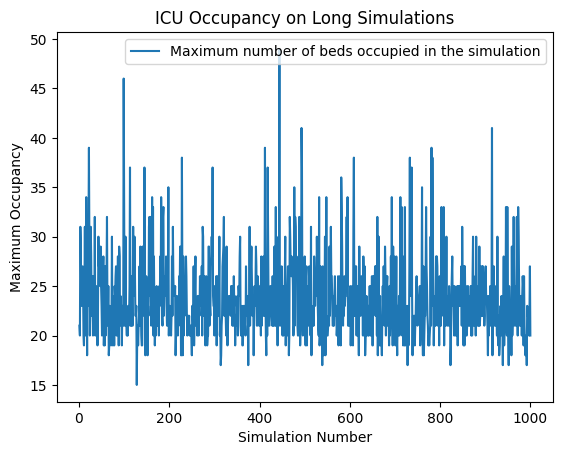

In [ ]:
# Plot the maximum occupancy during simulations
number_of_simulations = np.arange(1, num_simulations+1)

plt.plot(number_of_simulations, max_occupancy, label='Maximum number of beds occupied in the simulation')
plt.xlabel('Simulation Number')
plt.ylabel('Maximum Occupancy')
plt.title('ICU Occupancy on Long Simulations')
plt.legend()
plt.show()

In [ ]:
max(max_occupancy)

54

In [ ]:
min(max_occupancy)

16

## **Statistical Analysis of the Result of Ensemble of Simulations**

In [ ]:
import statistics
from statistics import mean
mean(max_occupancy)

23

In [ ]:
max_array = np.asarray(max_occupancy)
new_dataframe = pd.DataFrame({'Max_Occupancy': max_array})
pre_stat_df = new_dataframe.describe()
pre_stat_df

,Max_Occupancy
count,1000.000000
mean,23.317000
std,3.988787
min,16.000000
25%,21.000000
50%,23.000000
75%,25.000000
max,54.000000


In [ ]:
new_dataframe.head(100)

,Max_Occupancy
0,24
1,19
2,27
3,21
4,20
...,...
95,22
96,18
97,20
98,23


In [ ]:
new_dataframe['Max_Occupancy'].value_counts

<bound method IndexOpsMixin.value_counts of 0      24
1      19
2      27
3      21
4      20
       ..
995    25
996    18
997    20
998    28
999    19
Name: Max_Occupancy, Length: 1000, dtype: int64>

In [ ]:
new_dataframe.loc[new_dataframe['Max_Occupancy']>= 1.2174 * mean(max_occupancy)]

,Max_Occupancy
36,34
47,36
48,31
50,32
54,42
...,...
941,35
963,33
973,29
978,29


In [ ]:
1.2174 * mean(max_occupancy)

28.0002

In [ ]:
new_dataframe.loc[new_dataframe['Max_Occupancy']>= 1.3044 * mean(max_occupancy)]

,Max_Occupancy
36,34
47,36
48,31
50,32
54,42
63,35
123,35
124,40
157,33
169,31


In [ ]:
1.3044 * mean(max_occupancy)

30.0012

In [ ]:
data_table.enable_dataframe_formatter()
dict = {
        'Max_Occupancy':[28, 30]
       }

df_attached = pd.DataFrame(dict)
Statistic_df = pd.concat([pre_stat_df.iloc[:-1], df_attached, pre_stat_df.iloc[-1:]]).set_index(pd.Series(['No. of Simulations', 'mean', 'std', 'min', '25%' , '50%', '75%' , '90%' , '95%', 'max']))
Statistic_df

,Max_Occupancy
No. of Simulations,1000.000000
mean,23.317000
std,3.988787
min,16.000000
25%,21.000000
50%,23.000000
75%,25.000000
90%,28.000000
95%,30.000000
max,54.000000


In [ ]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

Statistic_df

,Max_Occupancy
No. of Simulations,1000.000000
mean,23.317000
std,3.988787
min,16.000000
25%,21.000000
50%,23.000000
75%,25.000000
90%,28.000000
95%,30.000000
max,54.000000
